In [47]:
# Import required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import yfinance as yf

In [27]:
def oneHotEncode(df, columns):
    all_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    all_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    all_days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
    all_days_of_week = [1, 2, 3, 4, 5, 6, 7]

    one_hot_encoded_df = pd.get_dummies(df, columns = columns)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'year_{year}' for year in all_years], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'month_{month}' for month in all_months], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'day_{day}' for day in all_days], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'day_of_week_{day_of_week}' for day_of_week in all_days_of_week], fill_value=0)

    print(one_hot_encoded_df.head())
    print(df.head())

    new_dataframe = pd.concat([df, one_hot_encoded_df], axis=1)

    return new_dataframe

In [56]:
# List of all stocks
stocks = ['aapl', 'amzn', 'googl', 'msft', 'tsla']

# Get rid of annoying errors that don't matter
pd.set_option('mode.chained_assignment', None)

# Create the scaler
sentimentScaler = MinMaxScaler()
stockScaler = MinMaxScaler()

# Create the datasets from the csvs
# Could use a lot of work to reduce loc but it doesn't matter for marks
def dataFrames(stock):

    # Create dataframes for the tweets and prices 
    tweet_df = pd.read_csv('csv/' + stock + '.csv')
    tweet_1_df = pd.read_csv('csv/' + stock + '_1.csv')
    price_df = pd.read_csv('csv/' + stock + '_price.csv')

    # Rename the date column so they match between dataframes
    tweet_df.rename(columns = {'DATE': 'date'}, inplace = True)
    tweet_1_df.rename(columns = {'Date': 'date'}, inplace = True)
    price_df.rename(columns = {'Date' : 'date', 'Close/Last': 'stockPrice'}, inplace = True)

    # Rename the score column so they match between dataframes
    tweet_df.rename(columns = {'TEXTBLOB_POLARITY': 'sentimentScore'}, inplace = True)
    tweet_1_df.rename(columns = {'score': 'sentimentScore'}, inplace = True)

    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    price_df['stockPrice'] = price_df['stockPrice'].str.replace('$', '')
    tweet_df['sentimentScore'] = pd.to_numeric(tweet_df['sentimentScore'])
    tweet_1_df['sentimentScore'] = pd.to_numeric(tweet_1_df['sentimentScore'])
    price_df['stockPrice'] = pd.to_numeric(price_df['stockPrice'])

    # Convert the dates to pd datetime
    price_df['date'] = pd.to_datetime(price_df['date'])
    tweet_df['date'] = pd.to_datetime(tweet_df['date'], dayfirst = True)
    tweet_1_df['date'] = pd.to_datetime(tweet_1_df['date'])

    # Reduce to only nessicary columns
    tweet_df = tweet_df[['date', 'sentimentScore']]
    tweet_1_df = tweet_1_df[['date', 'sentimentScore']]
    price_df = price_df[['date', 'stockPrice']]

    # Merge the dataframes based on the date column
    merged_1_df = pd.merge(tweet_df, price_df, on = 'date')
    merged_2_df = pd.merge(tweet_1_df, price_df, on = 'date')
    merged_df = pd.merge(merged_1_df, merged_2_df, how = 'outer')

    # Drop all duplicates
    final_df = merged_df.drop_duplicates()

    # Convert date to specific variables
    final_df['year'] = final_df['date'].dt.year
    final_df['month'] = final_df['date'].dt.month
    final_df['day'] = final_df['date'].dt.day
    final_df['day_of_week'] = final_df['date'].dt.dayofweek

    # One-hot encoding, should be done for all for financial data
    #final_df = oneHotEncode(final_df, ['year', 'month', 'day', 'day_of_week'])
    #final_df = pd.get_dummies(final_df, columns = ['year', 'month', 'day', 'day_of_week'])

    # Drop the original date column
    final_df = final_df.drop(columns = ['date'])

    # Save to csv for double checking
    #final_df.to_csv('final_' + stock + '.csv', index = False)

    # Scale the numerical values
    final_df[['sentimentScore']] = sentimentScaler.fit_transform(final_df[['sentimentScore']])
    final_df[['stockPrice']] = stockScaler.fit_transform(final_df[['stockPrice']])

    # Split into X and y
    X = final_df.drop(columns = ['stockPrice'])
    y = final_df['stockPrice']

    # Split the datasets into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    '''# Reshape the datasets
    X_train_reshaped = reshape_data(X_train)
    X_test_reshaped = reshape_data(X_test)'''

    # NOTE: Sequence length (1) could be improved by making one of the commented functions above work.
    X_train_reshaped = np.reshape(X_train, (-1, 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (-1,  1, X_test.shape[1]))
    y_train_array = y_train.values
    y_test_array = y_test.values

    # Return the training and test datasets
    return X_train_reshaped, X_test_reshaped, y_train_array, y_test_array

In [57]:
all_data = {}  # Dictionary to hold data for all stocks

for stock in stocks:
    # Run the 'dataFrames' function for each stock
    data = dataFrames(stock)
    
    # Store the datasets in the dictionary
    all_data[stock] = {
        'X_train': data[0],
        'X_test': data[1],
        'y_train': data[2],
        'y_test': data[3]
    }

    # Print the shapes of X_train and y_train for the current stock
    print(f"{stock} X_train shape: {data[0].shape}")
    print(f"{stock} y_train shape: {data[2].shape}")
    print(f"{stock} X_test shape: {data[1].shape}")

    sentimentScore  year  month  day  day_of_week
0         0.525862  2015      1    2            4
3         0.534483  2015      1    2            4
4         0.543103  2015      1    2            4
10        0.551724  2015      1    2            4
18        0.560345  2015      1    2            4
aapl X_train shape: (21542, 1, 5)
aapl y_train shape: (21542,)
aapl X_test shape: (5386, 1, 5)
    sentimentScore  year  month  day  day_of_week
0         0.329114  2015      1    2            4
1         0.367089  2015      1    2            4
9         0.379747  2015      1    2            4
10        0.392405  2015      1    2            4
12        0.405063  2015      1    2            4
amzn X_train shape: (19976, 1, 5)
amzn y_train shape: (19976,)
amzn X_test shape: (4995, 1, 5)
   sentimentScore  year  month  day  day_of_week
0        0.250000  2015      1    2            4
1        0.264706  2015      1    2            4
4        0.279412  2015      1    2            4
6        0.294

In [66]:
# Initialize dictionary to store the models for each stock
models = {}

for stock, datasets in all_data.items():
    X_train = datasets['X_train']
    y_train = datasets['y_train']
    X_test = datasets['X_test']
    y_test = datasets['y_test']
    print(X_train.shape)
    print(X_train)
    print(X_test.shape)
    
    # Define the model for current stock
    model = Sequential([
        LSTM(units=50, input_shape=(1, 5)),  # Specify input shape as (1, 5)
        Dense(units=1)  # Output layer
    ])

    # Convert data type of input arrays to float32
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')

    # Compile model using the Adam optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Ensure that X_train and y_train have the same number of samples (if necessary)
    X_train = X_train[:len(y_train)]

    # Fit the model with verbose settings for debugging
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    mc = ModelCheckpoint('best_model_{}.h5'.format(stock), monitor='val_loss', save_best_only=True)
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es, mc], verbose=1)

    # Evaluate the model and print the loss
    loss = model.evaluate(X_test, y_test)
    print(f"{stock} Test Loss: ", loss)

    # Store the model in the dictionary
    models[stock] = model

(21542, 1, 5)
[[[5.68965517e-01 2.01500000e+03 7.00000000e+00 2.10000000e+01
   1.00000000e+00]]

 [[5.94827586e-01 2.01900000e+03 6.00000000e+00 2.50000000e+01
   1.00000000e+00]]

 [[6.02330779e-01 2.01700000e+03 1.20000000e+01 2.90000000e+01
   4.00000000e+00]]

 ...

 [[5.86206897e-01 2.01500000e+03 3.00000000e+00 9.00000000e+00
   0.00000000e+00]]

 [[5.60344828e-01 2.01800000e+03 4.00000000e+00 2.40000000e+01
   1.00000000e+00]]

 [[6.03448276e-01 2.01900000e+03 5.00000000e+00 1.60000000e+01
   3.00000000e+00]]]
(5386, 1, 5)
169/169 [==============================] - 1s 2ms/step - loss: 0.0489
aapl Test Loss:  0.04889965429902077
(19976, 1, 5)
[[[3.79746835e-01 2.01600000e+03 8.00000000e+00 1.00000000e+01
   2.00000000e+00]]

 [[5.44303797e-01 2.01700000e+03 1.10000000e+01 1.60000000e+01
   3.00000000e+00]]

 [[4.68354430e-01 2.01700000e+03 6.00000000e+00 2.80000000e+01
   2.00000000e+00]]

 ...

 [[5.06329114e-01 2.01500000e+03 3.00000000e+00 2.70000000e+01
   4.00000000e+00]]



In [6]:
for stock, datasets in all_data.items():
    X_train = datasets['X_train']
    y_train = datasets['y_train']
    X_test = datasets['X_test']
    y_test = datasets['y_test']

    # Flatten X data for compatibility with RandomForest, Linear Regression, and Decision Tree
    num_samples, timesteps, num_features = X_train.shape
    X_train_2d = X_train.reshape(num_samples, timesteps * num_features)
    X_test_2d = X_test.reshape(X_test.shape[0], timesteps * num_features)

    # Store processed data
    all_data[stock] = (X_train_2d, X_test_2d, y_train, y_test)

# Initialize dictionaries for models and their performances
rf_models = {}
rf_losses = {}
lr_models = {}
lr_losses = {}
dt_models = {}
dt_losses = {}

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_2d, y_train)
    rf_predictions = rf_model.predict(X_test_2d)
    rf_loss = mean_squared_error(y_test, rf_predictions)
    rf_models[stock] = rf_model
    rf_losses[stock] = rf_loss
    print(f"{stock} Random Forest Test Loss: ", rf_loss)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_2d, y_train)
    lr_predictions = lr_model.predict(X_test_2d)
    lr_loss = mean_squared_error(y_test, lr_predictions)
    lr_models[stock] = lr_model
    lr_losses[stock] = lr_loss
    print(f"{stock} Linear Regression Test Loss: ", lr_loss)
    
    # Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train_2d, y_train)
    dt_predictions = dt_model.predict(X_test_2d)
    dt_loss = mean_squared_error(y_test, dt_predictions)
    dt_models[stock] = dt_model
    dt_losses[stock] = dt_loss
    print(f"{stock} Decision Tree Test Loss: ", dt_loss)

aapl Random Forest Test Loss:  4.1968745959621414e-10
aapl Linear Regression Test Loss:  0.011016191169306345
aapl Decision Tree Test Loss:  1.9007839717704197e-32
amzn Random Forest Test Loss:  1.1315437327411813e-09
amzn Linear Regression Test Loss:  0.010219437240305293
amzn Decision Tree Test Loss:  3.912598012761351e-32
googl Random Forest Test Loss:  5.083253809348119e-09
googl Linear Regression Test Loss:  0.006389820932366614
googl Decision Tree Test Loss:  3.846647740672896e-32
msft Random Forest Test Loss:  1.955834244360713e-09
msft Linear Regression Test Loss:  0.00498345298212116
msft Decision Tree Test Loss:  7.520586315893814e-33
tsla Random Forest Test Loss:  8.65813642465698e-09
tsla Linear Regression Test Loss:  0.02937480932458805
tsla Decision Tree Test Loss:  1.2126277193947334e-32


In [7]:
# Initialize dictionaries for GaussianNB models and their accuracies
gaussian_nb_models = {}
gaussian_nb_accuracies = {}

# Label encoder to convert continuous labels to discrete integers
label_encoder = LabelEncoder()

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # Convert continuous labels to discrete integers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Define and initialize the Gaussian Naive Bayes model
    bayes_model = GaussianNB()

    # Fit the model with the reshaped 2D training data and encoded labels
    bayes_model.fit(X_train_2d, y_train_encoded)

    # Make predictions on the reshaped 2D test data
    bayes_predictions = bayes_model.predict(X_test_2d)

    # Calculate and print the accuracy for the test set predictions
    accuracy = accuracy_score(y_test_encoded, bayes_predictions)
    print(f"{stock} Gaussian Naive Bayes Test Accuracy: ", accuracy)

    # Store the model and its accuracy
    gaussian_nb_models[stock] = bayes_model
    gaussian_nb_accuracies[stock] = accuracy

aapl Gaussian Naive Bayes Test Accuracy:  0.9658373561084292
amzn Gaussian Naive Bayes Test Accuracy:  0.9983983983983984
googl Gaussian Naive Bayes Test Accuracy:  0.9938168846611177
msft Gaussian Naive Bayes Test Accuracy:  0.9352248394004282
tsla Gaussian Naive Bayes Test Accuracy:  0.9822022296107961


In [67]:
predictions = {}
true_price = {}
final_tweets = {}
symbols = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']

def predictData(symbol, stock = 'aapl'):

    # Get the model for the stock
    current_price_data = [[168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45]]
    current_price_data = pd.DataFrame(current_price_data, columns=['stockPrice'])
    current_price_data['stockPrice'] = pd.to_numeric(current_price_data['stockPrice'])
    current_price_data['stockPrice'] = stockScaler.transform(current_price_data[['stockPrice']])
    
    # Get the true price
    y_true = current_price_data.values
    y_true = stockScaler.inverse_transform(y_true)

    # Get the current tweets
    current_tweets = pd.read_csv('csv/output.csv')
    current_tweets.rename(columns = {'Date': 'date'}, inplace = True)
    current_tweets.rename(columns = {'Sentiment': 'sentimentScore'}, inplace = True)
    
    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    current_tweets['sentimentScore'] = current_tweets['sentimentScore'].map(sentiment_mapping)
    current_tweets = current_tweets[['date', 'sentimentScore']]
    current_tweets['sentimentScore'] = pd.to_numeric(current_tweets['sentimentScore'])
    current_tweets['sentimentScore'] = sentimentScaler.transform(current_tweets[['sentimentScore']])

    # Convert the dates to pd datetime
    current_tweets['date'] = pd.to_datetime(current_tweets['date'])
    current_tweets['year'] = current_tweets['date'].dt.year
    current_tweets['month'] = current_tweets['date'].dt.month
    current_tweets['day'] = current_tweets['date'].dt.day
    current_tweets['day_of_week'] = current_tweets['date'].dt.dayofweek

    '''# Final changes
    X = current_tweets.drop(columns = ['date'])
    X = np.reshape(X, (-1, 1, X.shape[1]))
    X = X.astype('float32')'''

    # Use old data
    X = all_data[stock]['X_test']
    X = X.astype('float32')

    y_true = all_data[stock]['y_test']

    y_test = model.predict(X)
    y_test = stockScaler.inverse_transform(y_test)
    print(y_test)
    
    y_true = y_true.reshape(-1, 1)
    y_true = stockScaler.inverse_transform(y_true)
    predictions[stock] = y_test
    true_price[stock] = y_true
    final_tweets[stock] = X

# Predict for each stock
'''for stock in stocks:
    print(f"Predictions for {stock}:")
    predictData(stock)'''

predictData('AAPL')

169/169 [==============================] - 1s 2ms/step
[[18.02239]
 [18.02239]
 [18.02239]
 ...
 [18.02239]
 [18.02239]
 [18.02239]]


           date  stockPrice
0    2015-01-02   11.366811
1    2015-01-05   11.076683
2    2015-01-06   11.077625
3    2015-01-07   11.217979
4    2015-01-08   11.607957
...         ...         ...
1234 2019-12-24   27.845727
1235 2019-12-26   28.377001
1236 2019-12-27   28.366640
1237 2019-12-30   28.528659
1238 2019-12-31   28.729300

[1239 rows x 2 columns]


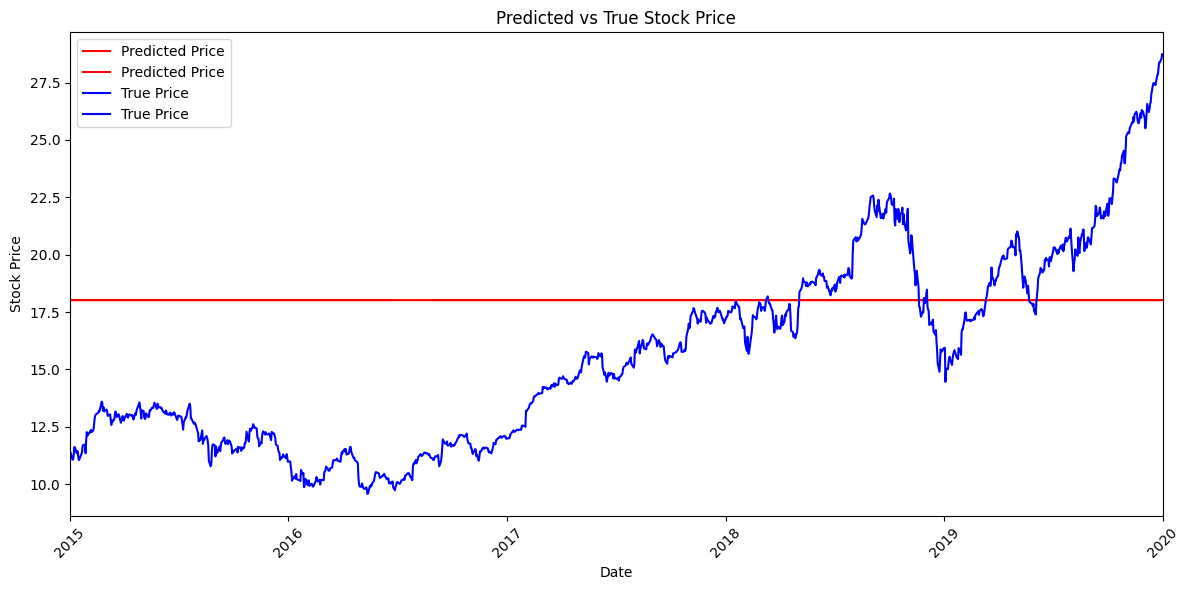

In [68]:
def plotPredictions(y_true, y_pred, X): 

    X_df = X.reshape(-1, X.shape[-1])
    X_df = pd.DataFrame(X_df, columns = ['sentimentScore', 'year', 'month', 'day', 'day_of_week'])
    X_df[['year', 'month', 'day', 'day_of_week']] = X_df[['year', 'month', 'day', 'day_of_week']].astype(int)

    X_df['date'] = X_df['year'].astype(str) + '-' + X_df['month'].astype(str) + '-' + X_df['day'].astype(str)
    X_df['date'] = pd.to_datetime(X_df['date'])

    X_df.drop(columns = ['year', 'month', 'day', 'day_of_week', 'sentimentScore'], inplace = True)

    y_pred_merged = pd.DataFrame(y_pred, columns = ['stockPrice'])
    y_true_merged = pd.DataFrame(y_true, columns = ['stockPrice'])

    y_pred_merged = pd.merge(X_df, y_pred_merged, left_index=True, right_index=True)
    y_true_merged = pd.merge(X_df, y_true_merged, left_index=True, right_index=True)   
    y_true_merged = y_true_merged.groupby('date')['stockPrice'].mean().reset_index()
    print(y_true_merged)

    plt.figure(figsize=(12, 6))
    plt.plot(y_pred_merged, y_pred_merged['stockPrice'], label = 'Predicted Price', color = 'red')
    plt.plot(y_true_merged, y_true_merged['stockPrice'], label = 'True Price', color = 'blue')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Predicted vs True Stock Price')
    plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'))
    plt.legend()
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

plotPredictions(true_price['aapl'], predictions['aapl'], final_tweets['aapl'])

In [10]:
def calculate_and_plot_metrics(y_true, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print metrics
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

    # Plot metrics
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("MSE")
    plt.bar(['MSE'], [mse])

    plt.subplot(1, 2, 2)
    plt.title("MAE")
    plt.bar(['MAE'], [mae])

    plt.show()

# Calculate and plot metrics for each stock
'''for stock in stocks:
    print(f"Metrics for {stock}:")
    y_true = true_price[stock]
    y_pred = predictions[stock]
    calculate_and_plot_metrics(y_true, y_pred)'''

print(f"Metrics for aapl:")
y_true = true_price['aapl']
y_pred = predictions['aapl']
calculate_and_plot_metrics(y_true, y_pred)

Metrics for aapl:


NameError: name 'mean_absolute_error' is not defined

In [ ]:
# Assuming y_true, X_test are defined, and model is trained

# Predict scores
y_scores = y_pred

# Find the optimal threshold
print(y_scores)
fpr, tpr, thresholds = roc_curve(y_true.astype(int), y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Convert the predicted values to binary based on the optimal threshold
y_pred_binary_optimal = np.where(y_scores > optimal_threshold, 1, 0)

# Calculate metrics using the binary values with the optimal threshold
accuracy_opt = accuracy_score(y_true.astype(int), y_pred_binary_optimal)
precision_opt = precision_score(y_true.astype(int), y_pred_binary_optimal)
recall_opt = recall_score(y_true.astype(int), y_pred_binary_optimal)
f1_opt = f1_score(y_true.astype(int), y_pred_binary_optimal)
roc_auc_opt = roc_auc_score(y_true.astype(int), y_scores)

# Print metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision: {precision_opt}")
print(f"Recall: {recall_opt}")
print(f"F1 Score: {f1_opt}")
print(f"ROC AUC: {roc_auc_opt}")

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values_opt = [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values_opt, color='skyblue')
plt.ylim([0.0, 1.0])
plt.title('Performance Metrics with Optimized Threshold')
plt.show()
